In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import LabelEncoder

In [2]:
dataset = pd.read_csv("dataset/dataset_final.csv")
print("Number of rows in the dataset:", len(dataset))

pd.set_option('display.max_columns', None)
dataset.head(10)

Number of rows in the dataset: 52160


,Driver,LapTime,LapNumber,Compound,TyreLife,FreshTyre,Team,EventName,Session,EventYear,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,FuelLevel
0,VER,91.295,3.0,SOFT,3.0,False,Red Bull Racing,Bahrain Grand Prix,Qualifying,2023,24.2,16.0,1017.5,False,28.7,352,0.6,2.0
1,VER,90.503,8.0,SOFT,2.0,True,Red Bull Racing,Bahrain Grand Prix,Qualifying,2023,23.8,20.0,1017.7,False,27.8,342,0.5,2.0
2,VER,89.897,11.0,SOFT,2.0,True,Red Bull Racing,Bahrain Grand Prix,Qualifying,2023,23.1,31.0,1017.7,False,26.9,338,1.3,2.0
3,VER,89.708,14.0,SOFT,2.0,False,Red Bull Racing,Bahrain Grand Prix,Qualifying,2023,23.0,33.0,1017.9,False,26.6,329,0.8,2.0
4,PER,91.479,3.0,SOFT,3.0,False,Red Bull Racing,Bahrain Grand Prix,Qualifying,2023,24.3,16.0,1017.5,False,28.7,333,0.4,2.0
5,PER,90.746,8.0,SOFT,2.0,True,Red Bull Racing,Bahrain Grand Prix,Qualifying,2023,23.8,20.0,1017.7,False,27.8,342,0.5,2.0
6,PER,90.131,11.0,SOFT,2.0,True,Red Bull Racing,Bahrain Grand Prix,Qualifying,2023,23.1,31.0,1017.7,False,26.9,338,1.3,2.0
7,PER,89.846,14.0,SOFT,2.0,False,Red Bull Racing,Bahrain Grand Prix,Qualifying,2023,23.0,33.0,1017.9,False,26.6,329,0.8,2.0
8,LEC,91.094,5.0,SOFT,2.0,True,Ferrari,Bahrain Grand Prix,Qualifying,2023,24.2,16.0,1017.5,False,28.7,352,0.6,2.0
9,LEC,91.699,10.0,SOFT,7.0,False,Ferrari,Bahrain Grand Prix,Qualifying,2023,23.8,20.0,1017.7,False,27.8,342,0.5,2.0


In [3]:
dataset.columns

Index(['Driver', 'LapTime', 'LapNumber', 'Compound', 'TyreLife', 'FreshTyre',
       'Team', 'EventName', 'Session', 'EventYear', 'AirTemp', 'Humidity',
       'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
       'FuelLevel'],
      dtype='object')

In [4]:
variables = {
    'LapTime': 'Lap time (s)',
    'EventName': 'Event name',
    'Team': 'Team name',
    'Compound': 'Tyre compound',
    'TyreLife': 'Tyre life (laps)',
    'FreshTyre': 'Fresh tyre',
    'FuelLevel': 'Fuel level (kg)',
    'AirTemp': 'Air temperature (°C)',
    'Humidity': 'Humidity (%)',
    'Pressure': 'Air pressure (mbar)',
    'Rainfall': 'Rainfall',
    'TrackTemp': 'Track temperature (°C)',
    'WindDirection': 'Wind direction (°)',
    'WindSpeed': 'Wind speed (m/s)'
}


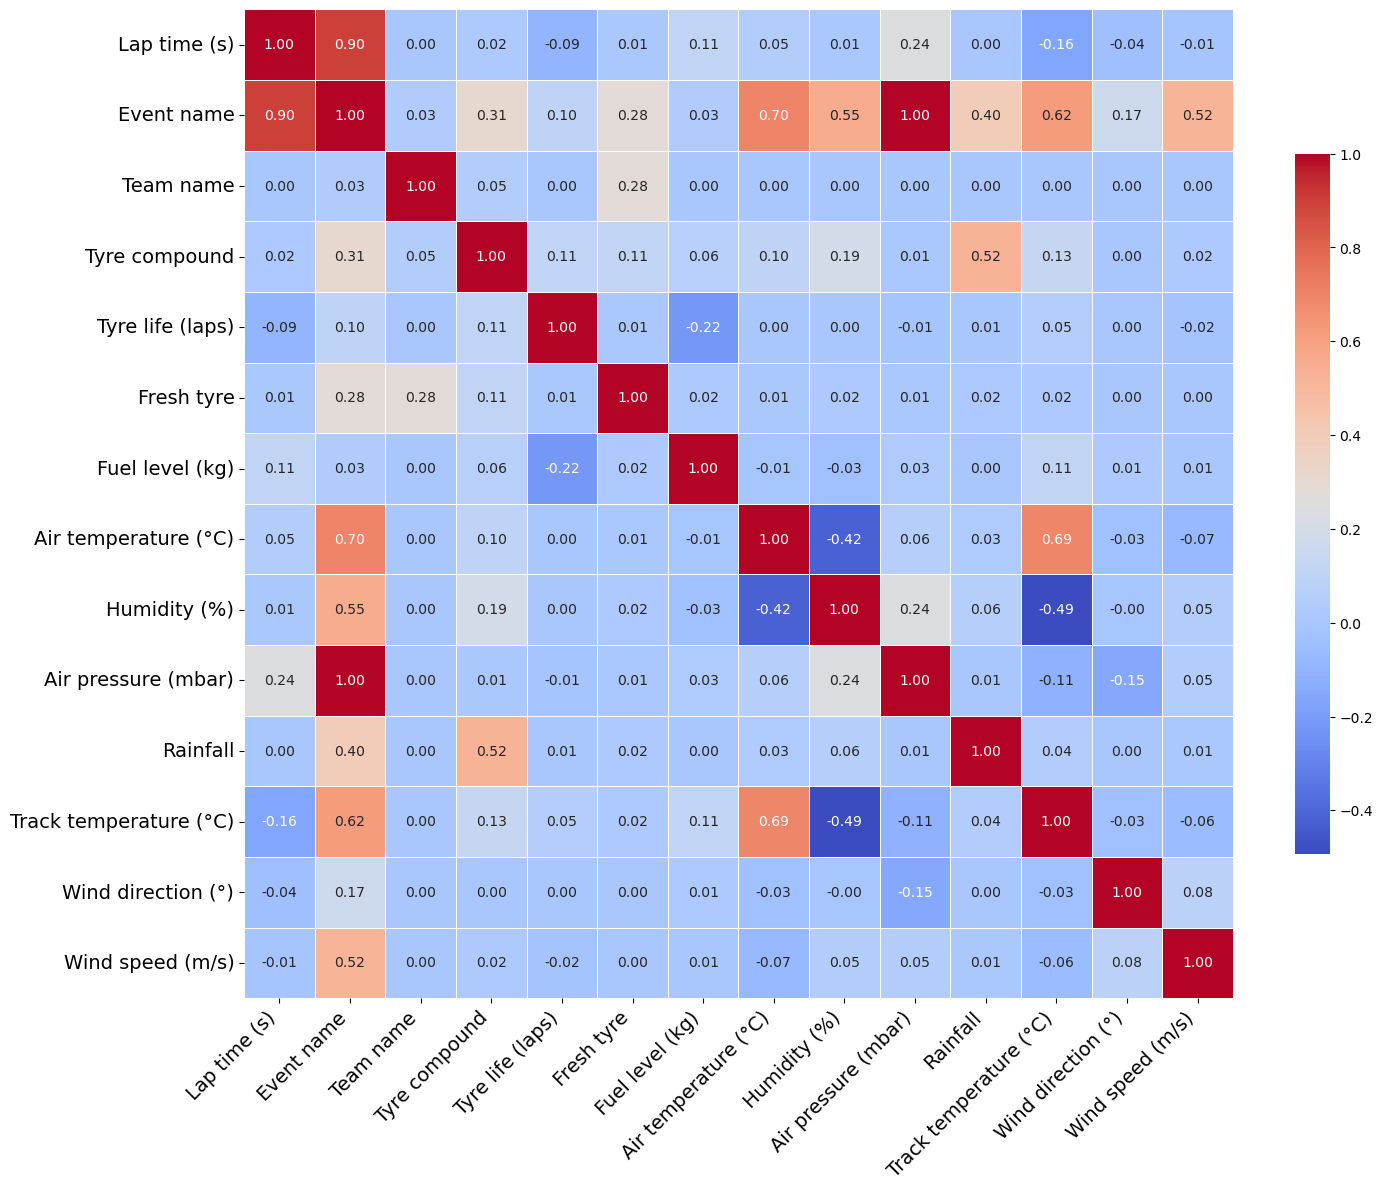

In [5]:
selected_cols = list(variables.keys())
df = dataset[selected_cols].copy()

def eta_squared(cat, num):
    try:
        categories = [num[cat == val] for val in np.unique(cat)]
        ss_between = sum(len(group) * (group.mean() - num.mean()) ** 2 for group in categories)
        ss_total = sum((num - num.mean()) ** 2)
        return ss_between / ss_total if ss_total > 0 else np.nan
    except:
        return np.nan

def cramers_v(x, y):
    try:
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.values.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
        rcorr = r - ((r - 1)**2)/(n - 1)
        kcorr = k - ((k - 1)**2)/(n - 1)
        denom = min((kcorr - 1), (rcorr - 1))
        return np.sqrt(phi2corr / denom) if denom > 0 else np.nan
    except:
        return np.nan

def mixed_correlation_matrix(df):
    cols = df.columns
    mat = pd.DataFrame(index=cols, columns=cols, dtype=float)

    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(exclude=[np.number]).columns

    for col in cat_cols:
        df[col] = df[col].astype(str)

    for i in cols:
        for j in cols:
            if i == j:
                mat.loc[i, j] = 1.0
            elif i in num_cols and j in num_cols:
                mat.loc[i, j] = df[[i, j]].corr().iloc[0, 1]
            elif i in cat_cols and j in cat_cols:
                mat.loc[i, j] = cramers_v(df[i], df[j])
            else:
                if i in cat_cols and j in num_cols:
                    mat.loc[i, j] = eta_squared(df[i], df[j])
                elif j in cat_cols and i in num_cols:
                    mat.loc[i, j] = eta_squared(df[j], df[i])
    return mat.astype(float)

corr_matrix = mixed_correlation_matrix(df)

corr_matrix.index = [variables[col] for col in corr_matrix.index]
corr_matrix.columns = [variables[col] for col in corr_matrix.columns]

plt.figure(figsize=(15, 15))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.5}
)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.tight_layout()
plt.show()

We can remove Pressure, Air temperature and Humidity

In [ ]:
# Standardization of original data points (mean 0 and std dev 1)
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

# Destandardization of standardized data points
def destandardize(z, mean, std):
    return z * std + mean

# Manual one-hot encoding for categorical variables
def one_hot_encode(values):
    unique = sorted(set(values))
    one_hot = np.zeros((len(values), len(unique)))
    for i, val in enumerate(values):
        one_hot[i][unique.index(val)] = 1
    return one_hot

# Build regression matrix A with bias column and target b
def build_model_data(X, y):
    num_samples = len(y)
    X = np.c_[np.ones(num_samples), X]
    return X, y

# Extract input variables from dataset
lap_time = dataset['LapTime']
event_name = dataset['EventName']
team = dataset['Team']
compound = dataset['Compound']
tyre_life = dataset['TyreLife']
fresh_tyre = dataset['FreshTyre']
fuel_level = dataset['FuelLevel']
#air_temp = dataset['AirTemp']
#humidity = dataset['Humidity']
#pressure = dataset['Pressure']
rainfall = dataset['Rainfall']
track_temp = dataset['TrackTemp']
wind_direction = dataset['WindDirection']
wind_speed = dataset['WindSpeed']

# One-hot encoding of categorical variables
event_oh = one_hot_encode(event_name)
team_oh = one_hot_encode(team)
compound_oh = one_hot_encode(compound)
fresh_tyre_oh = one_hot_encode(fresh_tyre)
rainfall_oh = one_hot_encode(rainfall)

X_num = np.c_[
    tyre_life,
    #air_temp,
    #humidity,
    #pressure,
    track_temp,
    wind_direction,
    wind_speed,
    fuel_level
]

X_features = np.c_[event_oh, team_oh, compound_oh, fresh_tyre_oh, rainfall_oh, X_num]
y_target = lap_time

X, y = build_model_data(X_features, y_target)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

num_numeric = X_num.shape[1]
num_start = event_oh.shape[1] + team_oh.shape[1] + compound_oh.shape[1] + fresh_tyre_oh.shape[1] + rainfall_oh.shape[1]


mu_X = np.mean(X_train[:, num_start:], axis=0)
std_X = np.std(X_train[:, num_start:], axis=0)
std_X[std_X == 0] = 1

X_train[:, num_start:] = (X_train[:, num_start:] - mu_X) / std_X
X_test[:, num_start:] = (X_test[:, num_start:] - mu_X) / std_X

mu_y = np.mean(y_train)
std_y = np.std(y_train)

y_train = (y_train - mu_y) / std_y
y_test = (y_test - mu_y) / std_y

In [7]:
def loss(w, X, y):
    return np.sum((X @ w - y) ** 2)

def grad(w, X, y):
    return 2 * X.T @ (X @ w - y)

# Print step info
def print_log(step, f_curr, grad_norm, batch_loss=None):
    if batch_loss is not None:
        print(f"[STEP {step:4d}] batch loss = {batch_loss:.5f} | f(x) = {f_curr:.5f} | ||grad|| = {grad_norm:.5f}")
    else:
        print(f"[STEP {step:5d}] f(x) = {f_curr:12.5f} | ||grad|| = {grad_norm:10.5f}")


In [8]:
#x_opt = np.linalg.pinv(X_train) @ y_train
#f_opt = loss(x_opt, X_train, y_train)

In [13]:
def mean_squared_error(y_true, y_pred):
    """Compute the Mean Squared Error (MSE) between true and predicted values."""
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    """Compute the Root Mean Squared Error (RMSE) between true and predicted values."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r2_score(y_true, y_pred):
    """Compute the coefficient of determination R² between true and predicted values."""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def get_results(X, y, x_final, mu_y, std_y):
    """
    Evaluate model performance in original units.
    X: feature matrix (with bias column)
    y: standardized target
    x_final: final weights
    mu_y, std_y: mean and std of original target (for destandardization)
    """
    # Compute predictions in the standardized space
    y_pred = X @ x_final
    # Destandardize predictions and targets to original units
    y_pred_denorm = y_pred * std_y + mu_y
    y_true_denorm = y * std_y + mu_y

    mse = mean_squared_error(y_true_denorm, y_pred_denorm)
    rmse = root_mean_squared_error(y_true_denorm, y_pred_denorm)
    r2 = r2_score(y_true_denorm, y_pred_denorm)

    print(f"R2:   {r2:.3f}")
    print(f"MSE:  {mse:.3f} s²")
    print(f"RMSE: {rmse:.3f} s")

In [9]:
#print("Train results:")
#get_results(X_train, y_train, x_opt, mu_y, std_y)

#print("\nTest results:")
#get_results(X_test, y_test, x_opt, mu_y, std_y)

---

In [ ]:
def gradient_descent(
    x0,
    grad_func,
    loss_func,
    learning_rate,
    max_iter,
    tol=1e-5,
    verbose=True
):

    x = x0.copy()
    x_vals = [x.copy()]            # Store iterates
    f_vals = [loss_func(x)]        # Store loss values
    
    for step in range(1, max_iter + 1):
        g = grad_func(x)
        grad_norm = np.linalg.norm(g)
        f_curr = loss_func(x)
        
        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break
        
        if verbose:
            print_log(step, f_curr, grad_norm, batch_loss=None)
        
        if grad_norm < tol:
            break
        
        gamma = learning_rate(step)
        x -= gamma * g
        
        x_vals.append(x.copy())
        f_vals.append(loss_func(x))
    
    return f_vals, x_vals


In [29]:
def gd(x0, gamma, max_iter, X, y):
    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: gamma,
        max_iter=max_iter
    )

def gd_lipschitz(x0, max_iter, X, y):
    x_opt = np.linalg.pinv(X.T @ X) @ X.T @ y
    R = np.linalg.norm(x0 - x_opt)
    B = 2 * (R * np.linalg.norm(X.T @ X)) + np.linalg.norm(X.T @ y)
    gamma = R / (B * np.sqrt(max_iter))
    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: gamma,  
        max_iter=max_iter
    )

def gd_smooth(x0, max_iter, X, y):
    H = X.T @ X
    L = 2 * np.linalg.norm(H, 2)
    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: 1.0 / L,
        max_iter=max_iter
    )


def gd_strongly_convex(x0, max_iter, X, y, not_strongly=False):
    H = X.T @ X 
    L = 2 * np.linalg.norm(H, 2)
    eigvals = np.linalg.eigvalsh(H)
    mu = 2 * np.min(eigvals)

    if mu <= 0:
        print("[X] The function is NOT STRONGLY CONVEX: µ <= 0")
        if not_strongly:
            return None, None

    return gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: 1.0 / L,
        max_iter=max_iter
    )


In [37]:
x0 = np.zeros(X.shape[1])
max_iter = 1000
gamma = 1e-5

print("[TRAIN] GD:")
f_gd, x_gd = gd(x0, gamma=gamma, max_iter=max_iter, X=X_train, y=y_train)

x_final = x_gd[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)


[TRAIN] GD:
[STEP     1] f(x) =  26080.00000 | ||grad|| = 12665.97059
[STEP     2] f(x) =  24585.43915 | ||grad|| = 11234.45040
[STEP     3] f(x) =  23365.04977 | ||grad|| = 10571.96449
[STEP     4] f(x) =  22272.76683 | ||grad|| = 10117.60944
[STEP     5] f(x) =  21268.56414 | ||grad|| = 9744.64310
[STEP     6] f(x) =  20335.23467 | ||grad|| = 9417.95130
[STEP     7] f(x) =  19462.34705 | ||grad|| = 9123.31516
[STEP     8] f(x) =  18642.48657 | ||grad|| = 8852.82018
[STEP     9] f(x) =  17870.00179 | ||grad|| = 8601.32245
[STEP    10] f(x) =  17140.40575 | ||grad|| = 8365.26085
[STEP    11] f(x) =  16450.02446 | ||grad|| = 8142.08885
[STEP    12] f(x) =  15795.77177 | ||grad|| = 7929.93997
[STEP    13] f(x) =  15174.99955 | ||grad|| = 7727.41353
[STEP    14] f(x) =  14585.39527 | ||grad|| = 7533.43329
[STEP    15] f(x) =  14024.91058 | ||grad|| = 7347.15271
[STEP    16] f(x) =  13491.71016 | ||grad|| = 7167.89081
[STEP    17] f(x) =  12984.13437 | ||grad|| = 6995.08822
[STEP    18] f(

In [38]:
print("[TRAIN] GD Lipschitz Convex:")
f_gd_L, x_gd_L = gd_lipschitz(x0, max_iter=max_iter, X=X_train, y=y_train)

x_final = x_gd_L[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] GD Lipschitz Convex:
[STEP     1] f(x) =  26080.00000 | ||grad|| = 12665.97059
[STEP     2] f(x) =  26052.24794 | ||grad|| = 12636.04707
[STEP     3] f(x) =  26024.62651 | ||grad|| = 12606.50794
[STEP     4] f(x) =  25997.13374 | ||grad|| = 12577.34659
[STEP     5] f(x) =  25969.76767 | ||grad|| = 12548.55653
[STEP     6] f(x) =  25942.52642 | ||grad|| = 12520.13143
[STEP     7] f(x) =  25915.40813 | ||grad|| = 12492.06505
[STEP     8] f(x) =  25888.41097 | ||grad|| = 12464.35128
[STEP     9] f(x) =  25861.53315 | ||grad|| = 12436.98413
[STEP    10] f(x) =  25834.77293 | ||grad|| = 12409.95772
[STEP    11] f(x) =  25808.12858 | ||grad|| = 12383.26630
[STEP    12] f(x) =  25781.59844 | ||grad|| = 12356.90420
[STEP    13] f(x) =  25755.18084 | ||grad|| = 12330.86589
[STEP    14] f(x) =  25728.87418 | ||grad|| = 12305.14590
[STEP    15] f(x) =  25702.67687 | ||grad|| = 12279.73891
[STEP    16] f(x) =  25676.58735 | ||grad|| = 12254.63966
[STEP    17] f(x) =  25650.60411 | ||grad||

In [39]:
print("[TRAIN] GD Smooth Convex:")
f_gd_S, x_gd_S = gd_smooth(x0, max_iter=max_iter, X=X_train, y=y_train)

x_final = x_gd_S[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] GD Smooth Convex:
[STEP     1] f(x) =  26080.00000 | ||grad|| = 12665.97059
[STEP     2] f(x) =  25121.57989 | ||grad|| = 11696.45820
[STEP     3] f(x) =  24291.41607 | ||grad|| = 11103.25542
[STEP     4] f(x) =  23537.30279 | ||grad|| = 10690.04711
[STEP     5] f(x) =  22835.33570 | ||grad|| = 10368.63345
[STEP     6] f(x) =  22173.42921 | ||grad|| = 10098.19796
[STEP     7] f(x) =  21544.74357 | ||grad|| = 9859.29273
[STEP     8] f(x) =  20944.91727 | ||grad|| = 9642.05201
[STEP     9] f(x) =  20370.86581 | ||grad|| = 9441.00351
[STEP    10] f(x) =  19820.23472 | ||grad|| = 9252.79019
[STEP    11] f(x) =  19291.13238 | ||grad|| = 9075.15239
[STEP    12] f(x) =  18781.98706 | ||grad|| = 8906.45560
[STEP    13] f(x) =  18291.46260 | ||grad|| = 8745.45737
[STEP    14] f(x) =  17818.40377 | ||grad|| = 8591.18235
[STEP    15] f(x) =  17361.79832 | ||grad|| = 8442.84855
[STEP    16] f(x) =  16920.74930 | ||grad|| = 8299.81967
[STEP    17] f(x) =  16494.45413 | ||grad|| = 8161.57204

In [31]:
print("[TRAIN] GD Strongly Convex:")
f_gd_S, x_gd_S = gd_strongly_convex(x0, max_iter=max_iter, X=X_train, y=y_train, not_strongly=True)

if x_gd_S is not None:
    x_final = x_gd_S[-1]
    get_results(X_test, y_test, x_final, mu_y, std_y)


[TRAIN] GD Strongly Convex:
[X] The function is NOT STRONGLY CONVEX: µ <= 0


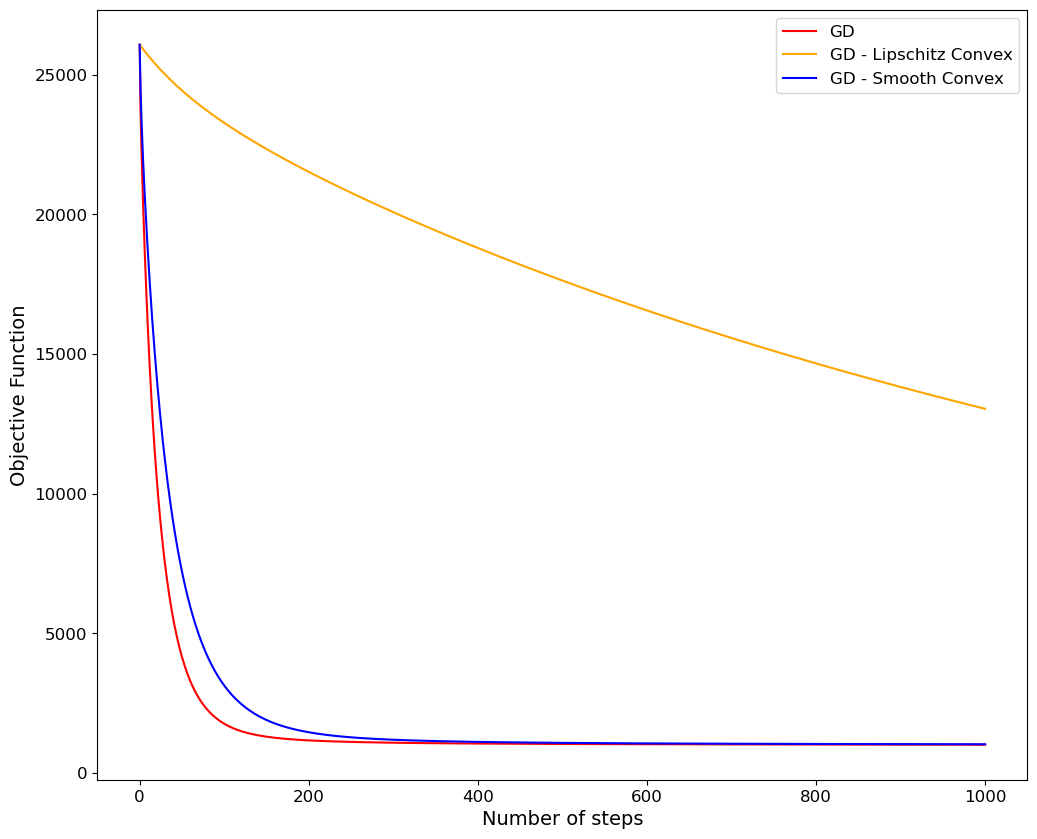

In [34]:
plt.figure(figsize=(12, 10))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot(range(len(f_gd)), f_gd, 'red', label='GD')
plt.plot(range(len(f_gd_L)), f_gd_L, 'orange', label='GD - Lipschitz Convex')
plt.plot(range(len(f_gd_S)), f_gd_S, 'blue', label='GD - Smooth Convex')
# plt.plot(range(len(f_gd_SC)), f_gd_SC, 'green', label='GD - Strongly Convex') function not strongly convex
plt.legend(loc='upper right', fontsize=12)
plt.show()


Supponiamo tutto smooth perchè migliore, non siamo riusciti a raggiungere comunque l'ottimo dopo 1000 iterazioni

---

**Forma penalizzata (Ridge Regression):**

$$
\min_{x} \; \mathcal{L}(x) = \|Xx - y\|^2 + \lambda \|x\|^2
$$

**Forma vincolata (equivalente con vincolo L2):**

$$
\min_{x} \; \|Xx - y\|^2 \quad \text{soggetto a} \quad \|x\|^2 \leq r
$$

In [18]:
def projection_l2_ball(x, radius=1.0):
    norm = np.linalg.norm(x)
    if norm > radius:
        return x / norm * radius
    else:
        return x

In [19]:
def projected_gradient_descent(
    x0,
    grad_func,
    loss_func,
    learning_rate,
    projection,
    max_iter,
    f_star=None,
    tol=1e-6,
    verbose=True
):
    
    x = x0.copy()
    x_vals = [x.copy()]            # Store iterates
    f_vals = [loss_func(x)]        # Store loss values
    
    for step in range(1, max_iter + 1):
        g = grad_func(x)               
        grad_norm = np.linalg.norm(g) 
        f_curr = loss_func(x)          
        
        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break
        
        if verbose and f_star is not None:
            print_log(step, f_curr, f_star, grad_norm)
        
        if grad_norm < tol:
            break
        
        gamma = learning_rate(step)   
        x = x - gamma * g             
        
        x = projection(x)             # Project back to feasible set
        
        x_vals.append(x.copy())
        f_vals.append(loss_func(x))
    
    return f_vals, x_vals

In [20]:
def pgd_smooth(x0, max_iter, X, y, radius):
    H = X.T @ X 
    L = np.linalg.norm(H, 2)
    return projected_gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss(x, X, y),
        learning_rate=lambda k: 1.0 / L,
        projection=lambda x: projection_l2_ball(x, radius),
        max_iter=max_iter,
        f_star=f_opt
    )

In [21]:
print("[TRAIN] PGD Smooth:")
f_pgd_S, x_pgd_S = pgd_smooth(x0, max_iter=max_iter, X=X_train, y=y_train, radius=5)

x_final = x_pgd_S[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] PGD Smooth:
[STEP    1] f(x) = 26080.00000 | f(x*) = 995.14774 | Δ = 2.51e+04 | ||grad|| = 1.66e+04
[STEP    2] f(x) = 23387.69355 | f(x*) = 995.14774 | Δ = 2.24e+04 | ||grad|| = 1.12e+04
[STEP    3] f(x) = 21903.07623 | f(x*) = 995.14774 | Δ = 2.09e+04 | ||grad|| = 1.02e+04
[STEP    4] f(x) = 20639.41935 | f(x*) = 995.14774 | Δ = 1.96e+04 | ||grad|| = 9.68e+03
[STEP    5] f(x) = 19495.70651 | f(x*) = 995.14774 | Δ = 1.85e+04 | ||grad|| = 9.28e+03
[STEP    6] f(x) = 18442.24959 | f(x*) = 995.14774 | Δ = 1.74e+04 | ||grad|| = 8.94e+03
[STEP    7] f(x) = 17465.36642 | f(x*) = 995.14774 | Δ = 1.65e+04 | ||grad|| = 8.62e+03
[STEP    8] f(x) = 16556.41916 | f(x*) = 995.14774 | Δ = 1.56e+04 | ||grad|| = 8.32e+03
[STEP    9] f(x) = 15708.82107 | f(x*) = 995.14774 | Δ = 1.47e+04 | ||grad|| = 8.04e+03
[STEP   10] f(x) = 14917.09526 | f(x*) = 995.14774 | Δ = 1.39e+04 | ||grad|| = 7.77e+03
[STEP   11] f(x) = 14176.51496 | f(x*) = 995.14774 | Δ = 1.32e+04 | ||grad|| = 7.52e+03
[STEP   12] 

In [22]:
event_categories = sorted(set(event_name))
team_categories = sorted(set(team))
compound_categories = sorted(set(compound))
fresh_tyre_categories = sorted(set(fresh_tyre))
rainfall_categories = sorted(set(rainfall))

event_feature_names = [f"Event name [{cat}]" for cat in event_categories]
team_feature_names = [f"Team [{cat}]" for cat in team_categories]
compound_feature_names = [f"Compound [{cat}]" for cat in compound_categories]
fresh_tyre_feature_names = [f"Fresh tyre [{cat}]" for cat in fresh_tyre_categories]
rainfall_feature_names = [f"Rainfall [{cat}]" for cat in rainfall_categories]

num_feature_names = [
    "Tyre life",
    #"Air temp",
    #"Humidity",
    #"Pressure",
    "Track temp",
    "Wind direction",
    "Wind speed",
    "Fuel level"
]

feature_names = (
    ["bias"] +
    event_feature_names +
    team_feature_names +
    compound_feature_names +
    fresh_tyre_feature_names +
    rainfall_feature_names +
    num_feature_names
)

coeff_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": x_final
})

def style_coeff(val, tol=1e-6):
    styles = []
    if abs(val) < tol:
        color = 'color: grey'
    else:
        color = 'color: green' if val > 0 else 'color: red'
    style = f'{color}; font-weight: bold'
    return style


row_styles = [
    {'selector': f'tbody tr:nth-child({i+1})', 'props': [('opacity', '0.4')]}
    for i, val in enumerate(coeff_df['Coefficient'])
    if abs(val) < 0.1
]

coeff_df_styled = (
    coeff_df.style
    .format({'Coefficient': '{:.3f}'})
    .map(style_coeff, subset=['Coefficient'])
    .set_table_styles(row_styles)
)

coeff_df_styled


,Feature,Coefficient
0,bias,0.182
1,Event name [Abu Dhabi Grand Prix],0.034
2,Event name [Australian Grand Prix],-0.669
3,Event name [Austrian Grand Prix],-1.736
4,Event name [Azerbaijan Grand Prix],1.661
5,Event name [Bahrain Grand Prix],0.784
6,Event name [Belgian Grand Prix],2.016
7,Event name [British Grand Prix],0.322
8,Event name [Canadian Grand Prix],-1.008
9,Event name [Chinese Grand Prix],1.188


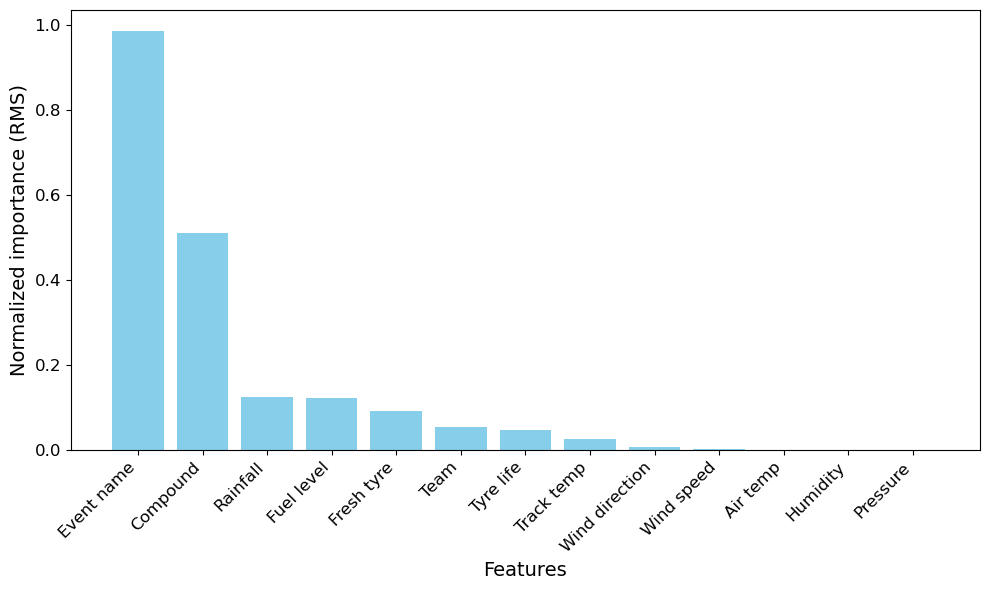

In [23]:
categorical_vars = {
    "Event name": event_feature_names,
    "Team": team_feature_names,
    "Compound": compound_feature_names,
    "Fresh tyre": fresh_tyre_feature_names,
    "Rainfall": rainfall_feature_names
}

numeric_feature_names = [
    "Tyre life",
    "Air temp",
    "Humidity",
    "Pressure",
    "Track temp",
    "Wind direction",
    "Wind speed",
    "Fuel level"
]

def plot_shrinkage(x_final): 

    coeff_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": x_final
    })

    # Exclude 'bias'
    coeff_df = coeff_df[coeff_df['Feature'] != 'bias']

    importance = {}

    # Categorical variables: RMS (root mean square) of dummy coefficients
    for var_name, dummy_features in categorical_vars.items():
        coeffs = coeff_df.loc[coeff_df['Feature'].isin(dummy_features), 'Coefficient'].values
        if len(coeffs) > 0:
            rms = np.sqrt(np.sum(coeffs**2) / len(coeffs))  # normalized L2
            importance[var_name] = rms
        else:
            importance[var_name] = 0

    # Numeric variables: absolute value of the single coefficient
    for num_var in numeric_feature_names:
        coeff = coeff_df.loc[coeff_df['Feature'] == num_var, 'Coefficient'].values
        if len(coeff) > 0:
            importance[num_var] = abs(coeff[0])
        else:
            importance[num_var] = 0

    # Sort by descending importance
    importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(importance.keys(), importance.values(), color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Normalized importance (RMS)', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.show()

plot_shrinkage(x_final)

---

## Lasso e Proximal Gradient Descent

La regressione **Lasso** minimizza la seguente funzione obiettivo:

$$
\min_{\beta} \left[ f(\beta) := \frac{1}{2} \|X\beta - y\|^2 + \lambda \|\beta\|_1 \right]
$$

Dove:

$$
\frac{1}{2} \|X\beta - y\|^2
$$  
è una funzione **differenziabile** (quadratica)

$$
\lambda \|\beta\|_1
$$  
è **non differenziabile** ma **convessa**


## Proximal Gradient Descent

Il **Proximal Gradient Descent** si applica a problemi del tipo:

$$
\min_\beta \left[ f(\beta) + g(\beta) \right]
$$

Dove:

$$
f(\beta)
$$  
è **differenziabile** con gradiente Lipschitz continuo

$$
g(\beta)
$$  
è **non differenziabile** ma ha un **operatore prossimale noto**


In [24]:
def loss_lasso(x, X, y, lam):
    return np.sum((X @ x - y) ** 2) + lam * np.linalg.norm(x, 1)

def soft_thresholding(x, thresh):
    return np.sign(x) * np.maximum(np.abs(x) - thresh, 0.0)

In [25]:
def proximal_gradient_descent(
    x0,
    grad_func,
    loss_func,
    prox_operator,
    learning_rate,
    lam,
    max_iter,
    f_star=None,
    tol=1e-6,
    verbose=True
):
    x = x0.copy()
    x_vals = [x.copy()]
    f_vals = [loss_func(x)]

    for step in range(1, max_iter + 1):
        g = grad_func(x)
        grad_norm = np.linalg.norm(g)
        f_curr = loss_func(x)

        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break

        if verbose and f_star is not None:
            print_log(step, f_curr, f_star, grad_norm)

        if grad_norm < tol:
            break

        gamma = learning_rate(step)
        x = prox_operator(x - gamma * g, gamma * lam)

        x_vals.append(x.copy())
        f_vals.append(loss_func(x))

    return f_vals, x_vals


In [26]:
def pxgd_smooth(x0, lam, max_iter, X, y):
    H = X.T @ X
    L = np.linalg.norm(H, 2)
    return proximal_gradient_descent(
        x0=x0,
        grad_func=lambda x: grad(x, X, y),
        loss_func=lambda x: loss_lasso(x, X, y, lam),
        prox_operator=soft_thresholding,
        learning_rate=lambda k: 1.0 / L,
        lam=lam,
        max_iter=max_iter,
        f_star=f_opt
    )

In [27]:
print("[TRAIN] PXGD Lasso Strongly Convex:")
f_pxgd_S, x_pxgd_S = pxgd_smooth(
    x0, lam=200, max_iter=max_iter, X=X_train, y=y_train
)

x_final = x_pxgd_S[-1]
get_results(X_test, y_test, x_final, mu_y, std_y)

[TRAIN] PXGD Lasso Strongly Convex:
[STEP    1] f(x) = 26080.00000 | f(x*) = 995.14774 | Δ = 2.51e+04 | ||grad|| = 1.66e+04
[STEP    2] f(x) = 23699.21184 | f(x*) = 995.14774 | Δ = 2.27e+04 | ||grad|| = 1.14e+04
[STEP    3] f(x) = 22424.27565 | f(x*) = 995.14774 | Δ = 2.14e+04 | ||grad|| = 1.03e+04
[STEP    4] f(x) = 21346.19359 | f(x*) = 995.14774 | Δ = 2.04e+04 | ||grad|| = 9.83e+03
[STEP    5] f(x) = 20371.12225 | f(x*) = 995.14774 | Δ = 1.94e+04 | ||grad|| = 9.44e+03
[STEP    6] f(x) = 19472.85770 | f(x*) = 995.14774 | Δ = 1.85e+04 | ||grad|| = 9.12e+03
[STEP    7] f(x) = 18639.70682 | f(x*) = 995.14774 | Δ = 1.76e+04 | ||grad|| = 8.81e+03
[STEP    8] f(x) = 17864.42514 | f(x*) = 995.14774 | Δ = 1.69e+04 | ||grad|| = 8.54e+03
[STEP    9] f(x) = 17141.51865 | f(x*) = 995.14774 | Δ = 1.61e+04 | ||grad|| = 8.27e+03
[STEP   10] f(x) = 16466.46733 | f(x*) = 995.14774 | Δ = 1.55e+04 | ||grad|| = 8.03e+03
[STEP   11] f(x) = 15835.51922 | f(x*) = 995.14774 | Δ = 1.48e+04 | ||grad|| = 7.79e

In [28]:
coeff_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": x_final
})

row_styles = [
    {'selector': f'tbody tr:nth-child({i+1})', 'props': [('opacity', '0.4')]}
    for i, val in enumerate(coeff_df['Coefficient'])
    if val == 0
]

coeff_df_styled = (
    coeff_df.style
    .format({'Coefficient': '{:.3f}'})
    .map(style_coeff, subset=['Coefficient'])
    .set_table_styles(row_styles)
)

coeff_df_styled

,Feature,Coefficient
0,bias,-0.000
1,Event name [Abu Dhabi Grand Prix],0.000
2,Event name [Australian Grand Prix],-0.463
3,Event name [Austrian Grand Prix],-1.500
4,Event name [Azerbaijan Grand Prix],1.747
5,Event name [Bahrain Grand Prix],0.651
6,Event name [Belgian Grand Prix],2.021
7,Event name [British Grand Prix],0.211
8,Event name [Canadian Grand Prix],-0.809
9,Event name [Chinese Grand Prix],1.024


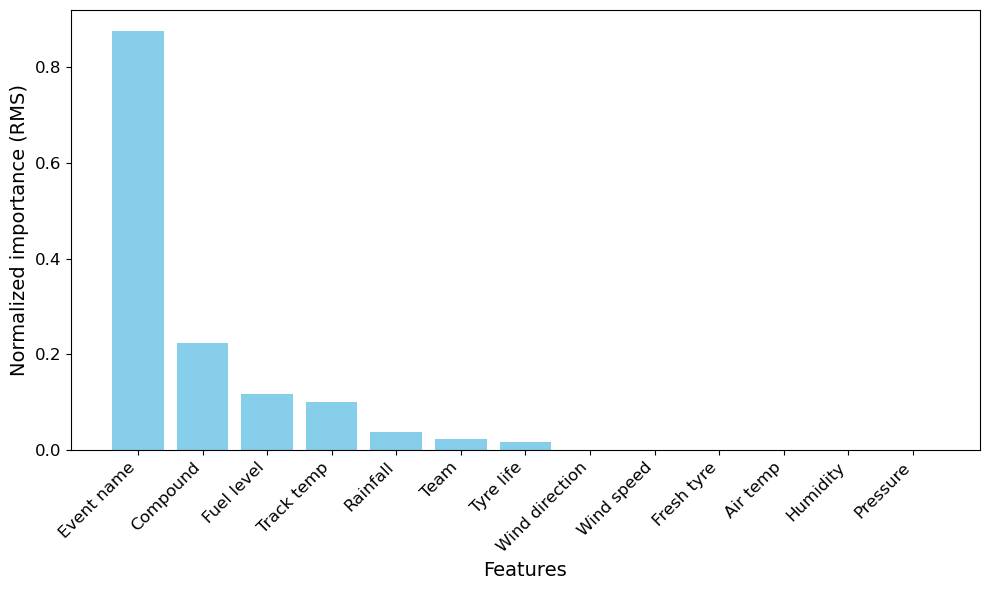

In [29]:
plot_shrinkage(x_final)

---

In [30]:
def stochastic_gradient_descent(
    x0,
    X,
    y,
    grad_func,
    loss_func,
    learning_rate=None,
    max_iter=1000,
    batch_size=1,
    f_star=None,
    tol=1e-6,
    verbose=True
):
    n = X.shape[0]
    x = x0.copy()
    x_vals = [x.copy()]
    f_vals = []

    for step in range(1, max_iter + 1):
        # Casual batch extraction  
        idx = np.random.choice(n, batch_size, replace=False)
        X_batch = X[idx] if isinstance(X, np.ndarray) else X.iloc[idx]
        y_batch = y[idx] if isinstance(y, np.ndarray) else y.iloc[idx]
        
        f_curr = loss_func(x, X_batch, y_batch)
        grad = grad_func(x, X_batch, y_batch, batch_size)
        grad_norm = np.linalg.norm(grad)
        
        f_vals.append(f_curr)

        if np.isnan(f_curr) or f_curr > 1e6:
            print("STOP - Divergence detected")
            break

        if verbose and f_star is not None:
            full_loss = loss_func(x, X, y)
            print_log(step, full_loss, f_star, grad_norm, batch_loss=f_curr)

        if grad_norm < tol:
            break

        gamma = learning_rate(step) if learning_rate is not None else 1e-3
        x -= gamma * grad
        x_vals.append(x.copy())

    return f_vals, x_vals

In [31]:
def batch_loss(x, X_b, y_b):
    return np.mean((X_b @ x - y_b) ** 2)
    
def batch_grad(x, X_b, y_b, batch_size):
    return 2 * X_b.T @ (X_b @ x - y_b) / batch_size

In [32]:
def sgd(x0, gamma, max_iter, X, y, batch_size=1):
    return stochastic_gradient_descent(
        x0=x0,
        X=X,
        y=y,
        grad_func=batch_grad,
        loss_func=batch_loss,
        learning_rate=lambda k: gamma,
        max_iter=max_iter,
        batch_size=batch_size,
        f_star=f_opt
    )

def sgd_lipschitz(x0, max_iter, X, y, batch_size):
    n = X.shape[0]
    R = np.linalg.norm(x0 - x_opt)
    B = (2/n) * (R * np.linalg.norm(X.T @ X) + np.linalg.norm(X.T @ y))
    gamma = R / (B * np.sqrt(max_iter))
    return stochastic_gradient_descent(
        x0=x0, 
        X=X, 
        y=y, 
        grad_func=batch_grad,
        loss_func=batch_loss,
        learning_rate=lambda k: gamma, 
        max_iter=max_iter,
        batch_size=batch_size,
        f_star=f_opt
    )

def sgd_strongly_convex(x0, max_iter, X, y, batch_size):
    H = X.T @ X
    eigvals = np.linalg.eigvalsh(H)
    mu = 2 * np.min(eigvals) / X.shape[0]
    if mu <= 0:
        print("[X] The function is NOT STRONGLY CONVEX: µ <= 0")
        gamma0 = 1e-5  # fallback
    else:
        gamma0 = 2 / mu
    return stochastic_gradient_descent(
        x0=x0,
        X=X,
        y=y,
        grad_func=batch_grad,
        loss_func=batch_loss,
        learning_rate=lambda k: gamma0 / (k + 1),
        max_iter=max_iter,
        batch_size=batch_size,
        f_star=f_opt
    )


In [33]:
x_opt = np.linalg.pinv(X_train) @ y_train
f_opt = loss(x_opt, X_train, y_train)

In [34]:
gamma = 1e-1
batch_size = 128  # 1 for real SDG

print("[TRAIN] SGD:")
f_sgd, x_sgd = sgd(x0, gamma=gamma, max_iter=max_iter, X=X_train, y=y_train, batch_size=batch_size)

x_final_sgd = x_sgd[-1]
get_results(X_test, y_test, x_final_sgd, mu_y, std_y)

[TRAIN] SGD:
[STEP    1] batch loss = 1.00380 | f(x) = 1.00000 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 8.71e-01
[STEP    2] batch loss = 0.86868 | f(x) = 0.95695 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 6.77e-01
[STEP    3] batch loss = 0.97367 | f(x) = 0.93961 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 1.04e+00
[STEP    4] batch loss = 0.77640 | f(x) = 0.91160 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 8.46e-01
[STEP    5] batch loss = 0.85003 | f(x) = 0.89012 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 6.08e-01
[STEP    6] batch loss = 1.26258 | f(x) = 0.87342 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 9.95e-01
[STEP    7] batch loss = 0.74114 | f(x) = 0.86179 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 5.38e-01
[STEP    8] batch loss = 1.03761 | f(x) = 0.84544 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 5.54e-01
[STEP    9] batch loss = 0.70142 | f(x) = 0.83611 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 5.97e-01
[STEP   10] bat

In [35]:
print("[TRAIN] SGD Lipschitz Convex:")
f_sgd_L, x_sgd_L = sgd_lipschitz(x0,  max_iter=max_iter, X=X_train, y=y_train, batch_size=batch_size)

x_final = x_sgd_L[-1]
get_results(X_test, y_test, x_final_sgd, mu_y, std_y)

[TRAIN] SGD Lipschitz Convex:
[STEP    1] batch loss = 0.95317 | f(x) = 1.00000 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 7.47e-01
[STEP    2] batch loss = 0.94491 | f(x) = 0.99851 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 7.51e-01
[STEP    3] batch loss = 1.07319 | f(x) = 0.99743 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 8.52e-01
[STEP    4] batch loss = 1.08428 | f(x) = 0.99565 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 1.06e+00
[STEP    5] batch loss = 0.85981 | f(x) = 0.99378 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 5.63e-01
[STEP    6] batch loss = 0.95895 | f(x) = 0.99269 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 9.47e-01
[STEP    7] batch loss = 0.86393 | f(x) = 0.99091 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 8.57e-01
[STEP    8] batch loss = 1.17728 | f(x) = 0.98961 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 8.77e-01
[STEP    9] batch loss = 1.06281 | f(x) = 0.98787 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 8.59e-0

In [36]:
print("[TRAIN] SGD Strongly Convex:")
f_sgd_SC, x_sgd_SC = sgd_strongly_convex(x0,  max_iter=max_iter, X=X_train, y=y_train, batch_size=batch_size)

x_final = x_sgd_SC[-1]
get_results(X_test, y_test, x_final_sgd, mu_y, std_y)

[TRAIN] SGD Strongly Convex:
[X] The function is NOT STRONGLY CONVEX: µ <= 0
[STEP    1] batch loss = 1.13191 | f(x) = 1.00000 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 9.77e-01
[STEP    2] batch loss = 0.97281 | f(x) = 1.00000 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 8.72e-01
[STEP    3] batch loss = 1.04170 | f(x) = 1.00000 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 8.31e-01
[STEP    4] batch loss = 0.83468 | f(x) = 1.00000 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 6.88e-01
[STEP    5] batch loss = 1.07101 | f(x) = 0.99999 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 7.19e-01
[STEP    6] batch loss = 0.81728 | f(x) = 0.99999 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 8.32e-01
[STEP    7] batch loss = 0.93145 | f(x) = 0.99999 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 8.41e-01
[STEP    8] batch loss = 1.12807 | f(x) = 0.99999 | f(x*) = 995.14774 | Δ = -9.94e+02 | ||grad|| = 1.08e+00
[STEP    9] batch loss = 0.93582 | f(x) = 0.99999 | f(x*) =

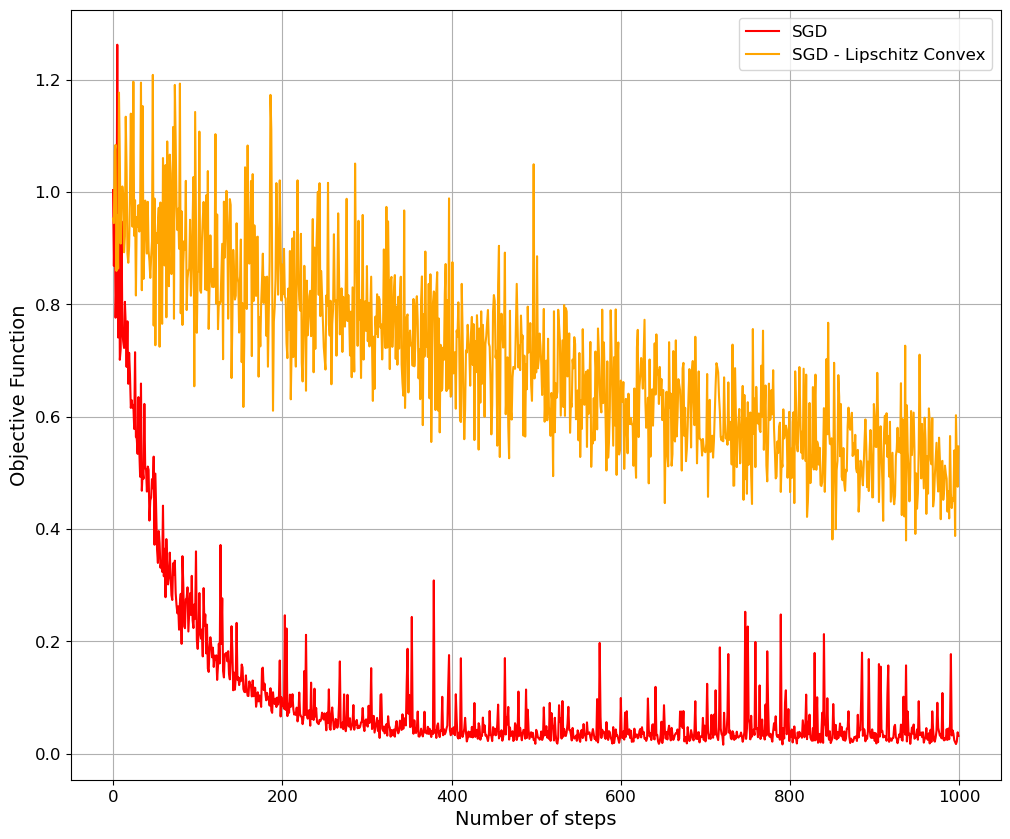

In [37]:
plt.figure(figsize=(12, 10))  
plt.xlabel('Number of steps', fontsize=14)
plt.ylabel('Objective Function', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.plot(range(len(f_sgd)), f_sgd, color='red', label='SGD')
plt.plot(range(len(f_sgd_L)), f_sgd_L, color='orange', label='SGD - Lipschitz Convex')
# plt.plot(range(len(f_sgd_S)), f_gd_S, color='blue', label='SGD - Smooth Convex') function not smooth
# plt.plot(range(len(f_sgd_SC)), f_gd_SC, color='green', label='SGD - Strongly Convex') function not strongly convex

plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()


---

In [38]:
def loss(x, X, y):
    return np.mean((X @ x - y) ** 2)

def grad(x, X, y):
    return (2 / X.shape[0]) * X.T @ (X @ x - y)
